In [1]:
%load_ext autoreload
%autoreload 2
from imports.data import *
from imports.params import p
from imports.utility import *
import matplotlib.pyplot as plt

# shot noise

In [11]:
z = 0.05
H0 = 70 #km/s/Mpc
c = 3e5 #km/s
r = c*z/H0 * 3.08567758e22 #m
telescope_diameter = 1 #m
telescope_surface = np.pi * (telescope_diameter/2)**2 #m^2
flux_ratio = telescope_surface / (4*np.pi*r**2*(1+z)) #frac of luminosity that arrives at distance r on telescope surface

exposure_time = 100000 #s

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
38


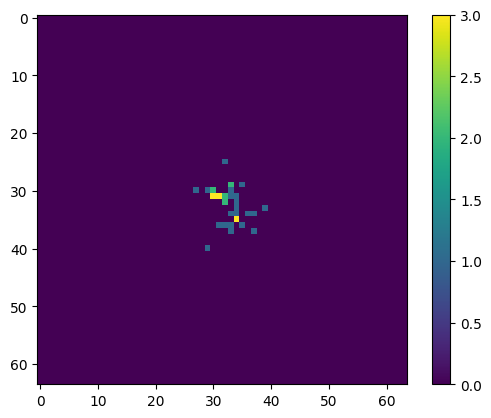

/var/tmp/tol/ipykernel_1132493/1930136196.py:11: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(photon_counts[i, 1]))


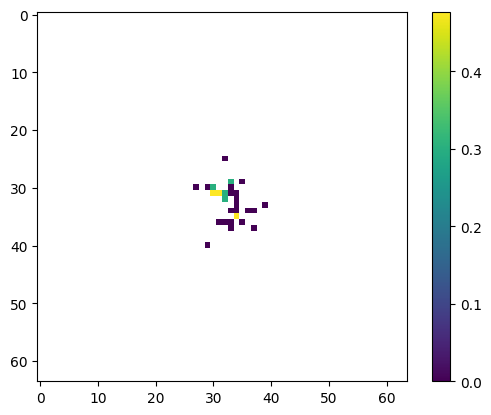

In [12]:
# p["model"] = "HYDRO_FIDUCIAL"
# data = Data(p)
# filename = p_to_filename(p)
# photon_counts = np.load(p["data_path"] + filename + "_photons.npy")
# i = 2902
# print(photon_counts[i, 1])
# print(np.sum(photon_counts[i, 1]))
# plt.imshow(photon_counts[i, 1])
# plt.colorbar()
# plt.show()
# plt.imshow(np.log10(photon_counts[i, 1]))
# plt.colorbar()
# plt.show()

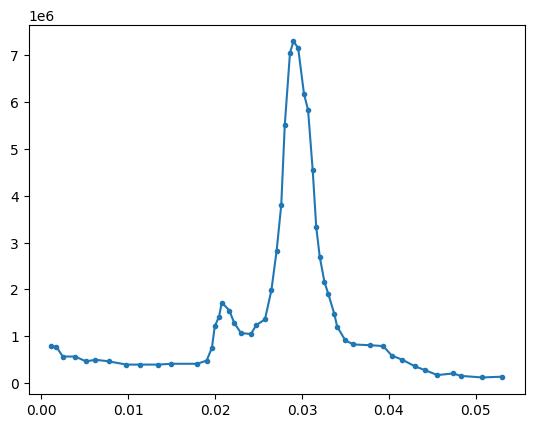

In [13]:
from scipy.optimize import curve_fit
noisedata = np.loadtxt(p["model_path"]+"background_counts.txt", delimiter=",")
plt.plot(noisedata[:,0], noisedata[:,1], marker=".")
plt.show()

In [14]:
def gauss(x, *p):
    A, mu, sigma = p
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

p0 = [7*1e6, 0.03, 0.01]
coeff, var_matrix = curve_fit(gauss, noisedata[:,0], noisedata[:,1], p0=p0)
print(coeff)

[6.94999874e+06 2.94732021e-02 2.02338343e-03]


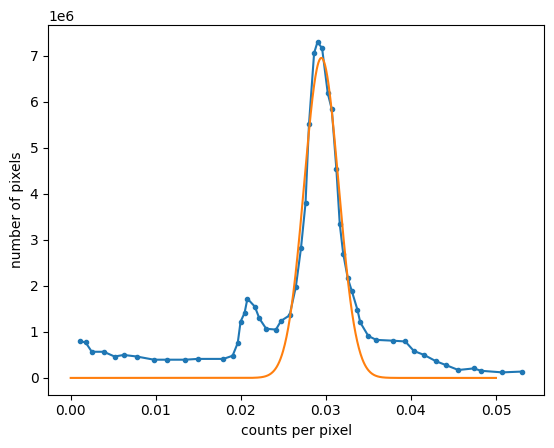

In [15]:
x = np.linspace(0, 0.05, 1000)
plt.plot(noisedata[:,0], noisedata[:,1], marker=".")
plt.plot(x, gauss(x, coeff[0], coeff[1], coeff[2]))
plt.xlabel("counts per pixel")
plt.ylabel("number of pixels")
plt.show()

In [16]:
erosita_pixels = 384
erosita_radius = 0.358/2
erosita_exposure_depth = 2200
telescope_radius = 0.5

pixelratio = (erosita_pixels*erosita_pixels) / (p["resolution"]*p["resolution"])
surface_ratio = (np.pi*(telescope_radius)**2)/(np.pi*erosita_radius**2)
exposure_ratio = exposure_time / erosita_exposure_depth
ratio = pixelratio*surface_ratio*exposure_ratio

print(ratio)


12767.732252142852


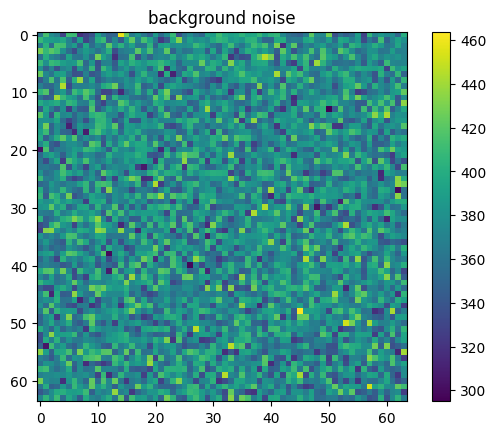

In [17]:
plt.imshow(np.random.normal(loc=coeff[1]*ratio, scale=coeff[2]*ratio, size=(p["resolution"], p["resolution"])))
plt.title("background noise")
plt.colorbar()
plt.show()

In [18]:
for model in ["HYDRO_FIDUCIAL"]:# ["HYDRO_FIDUCIAL", "HYDRO_JETS_published", "HYDRO_STRONG_AGN", "HYDRO_STRONG_JETS_published", "HYDRO_STRONG_SUPERNOVA", "HYDRO_STRONGER_AGN", "HYDRO_STRONGER_AGN_STRONG_SUPERNOVA", "HYDRO_STRONGEST_AGN", "HYDRO_WEAK_AGN"]:
    p["model"] = model
    data = Data(p)
    filename = p_to_filename(p)
    data.load_dataset(filename=filename)
    norm_images = data.images / np.sum(data.images, axis=(2, 3))[:,:,np.newaxis, np.newaxis]
    photon_luminosities = data.soap_file[f"{p['selection_type']}/XRayPhotonLuminosityWithoutRecentAGNHeating"][()][data.indices, :2] #/s

    

    photon_counts = np.random.poisson(norm_images * photon_luminosities[:, :, np.newaxis, np.newaxis] * flux_ratio * exposure_time)
    background_noise = np.random.normal(loc=coeff[1]*ratio, scale=coeff[2]*ratio, size=photon_counts.shape)
    # photon_counts[photon_counts == 0] = 1

    np.save(p["data_path"] + filename + "_photons", photon_counts)
    print(model, "done")

# plt.imshow(np.log10(photon_counts[-1, 1]))
# plt.colorbar()
# plt.show()


# test saved data

In [2]:
p["channel"] = "2chan"
# p["soapfile"] = "halo_properties_0078.hdf5"
# p["snapshot"] = "flamingo_0078/flamingo_0078.hdf5"
# p["snapshot_folder"] = "snapshots_reduced"
# p["simsize"] = "L2800N5040"
p["model"] = "HYDRO_FIDUCIAL"
data = Data(p)
filename = p_to_filename(p)
data.load_dataset(filename=filename)
print(data.images.shape)

ids_to_remove = np.unique(np.where(data.images == 0)[0])
print(ids_to_remove)
print(len(ids_to_remove))

(7933, 2, 64, 64)
[]
0


In [4]:
test = np.load(p["data_path"] + p_to_filename(p) + "_photons.npy")

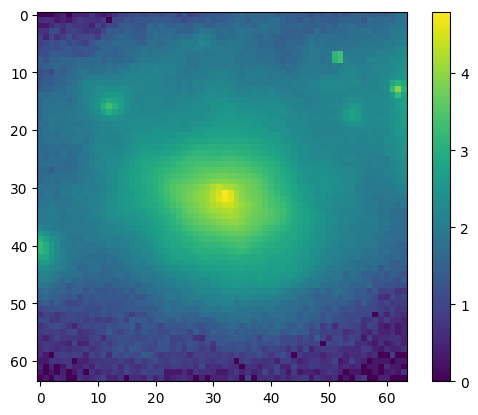

In [21]:
plt.imshow(np.log10(test[4000,0]))
plt.colorbar()

In [5]:
print(np.sum(data.soap_file["SO/500_crit/TotalMass"][()] > 1e13))

92015


[13.         13.22222222 13.44444444 13.66666667 13.88888889 14.11111111
 14.33333333 14.55555556 14.77777778 15.        ]


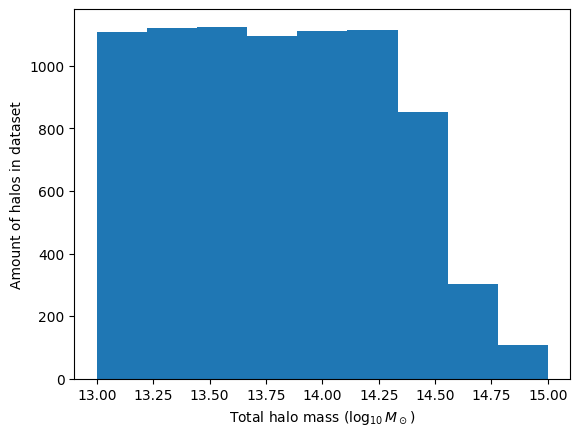

In [17]:
logbins = np.log10(np.logspace(13, 15, 10))
print(logbins)
plt.hist(np.log10(data.masses), bins = logbins)
plt.xlabel(r"Total halo mass ($\log_{10}M_\odot$)")
plt.ylabel("Amount of halos in dataset")
plt.savefig("mass_distribution", dpi=200)
plt.show()

In [2]:
for model in ["HYDRO_FIDUCIAL", "HYDRO_JETS_published", "HYDRO_STRONG_AGN", "HYDRO_STRONG_JETS_published", "HYDRO_STRONG_SUPERNOVA", "HYDRO_STRONGER_AGN", "HYDRO_STRONGER_AGN_STRONG_SUPERNOVA", "HYDRO_STRONGEST_AGN", "HYDRO_WEAK_AGN"]:
# for i in range(1, 6):
    # p["soapfile"] = "halo_properties_0078.hdf5"
    # p["snapshot"] = "flamingo_0078/flamingo_0078.hdf5"
    # p["snapshot_folder"] = "snapshots_reduced"
    # p["simsize"] = "L2800N5040"
    p["model"] = model
    data = Data(p)
    filename = p_to_filename(p) #+ str(i)
    indices = np.load(p["data_path"] + filename + "_halo_indices.npy")
    dmmasses = data.soap_file[f"{p['selection_type']}/DarkMatterMass"][()][indices]
    # print(indices.shape)
    # print(masses.shape)
    # print(np.load(p["data_path"] + filename + "_masses.npy").shape)
    
    np.save(p["data_path"] + filename + "_dmmasses", dmmasses)

In [56]:
for i in range(len(data.images)):
    data.images[i][data.images[i] == 0] = 1

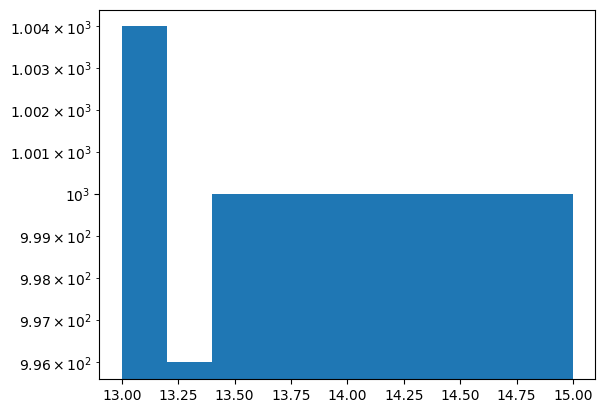

In [35]:
plt.hist(np.log10(data.masses), bins=10)
plt.yscale("log")

In [11]:
###remove image from data and save
print(data.images.shape)
print(data.indices.shape)
data.images = np.delete(data.images, ids_to_remove, axis=0)
data.indices = np.delete(data.indices, ids_to_remove)
print(data.images.shape)
print(data.indices.shape)

(7941, 2, 64, 64)
(7941,)
(7934, 2, 64, 64)
(7934,)


In [57]:
np.save(p["data_path"] + filename, data.images)
np.save(p["data_path"] + filename + "_halo_indices", data.indices)

(array([114.,  86., 120.,  83., 104., 109., 104., 105., 100.,  79., 100.,
        107.,  92., 107.,  93., 126., 115.,  85.,  88.,  83., 108., 101.,
        109.,  94.,  91., 118.,  90.,  98., 111.,  80., 116., 106., 113.,
         87.,  78.,  95., 107., 112.,  92.,  94., 100., 102., 114.,  99.,
         87., 126., 107., 101.,  81.,  83., 111.,  99., 104.,  96.,  93.,
        103., 111., 107.,  99.,  77.,  94., 106., 114., 107.,  80., 118.,
        108.,  91.,  97.,  85., 112., 120.,  82.,  82., 104., 128.,  86.,
        116.,  85.,  85., 126., 106.,  92.,  93.,  83., 109., 111.,  98.,
         94.,  88., 115., 115.,  98.,  81.,  91., 118., 124.,  96.,  82.,
         80.]),
 array([13.00068855, 13.02067947, 13.04067039, 13.06066036, 13.08065128,
        13.1006422 , 13.12063313, 13.14062405, 13.16061497, 13.18060493,
        13.20059586, 13.22058678, 13.2405777 , 13.26056862, 13.28055859,
        13.30054951, 13.32054043, 13.34053135, 13.36052227, 13.38051319,
        13.40050316, 13.42

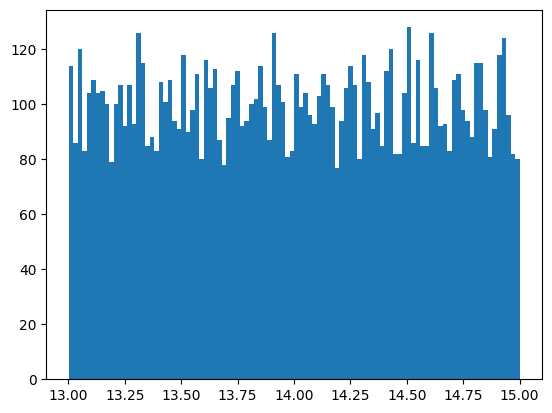

In [20]:
# halo_indices = np.load(p["data_path"] + filename + "_halo_indices" + ".npy")
# print(halo_indices.shape)
# print(data.soap_file[f"{p['selection_type']}/TotalMass"][()][halo_indices])
plt.hist(np.log10(data.soap_file[f"{p['selection_type']}/TotalMass"][()][halo_indices]), bins=100)
# np.save(p["data_path"] + p_to_filename(p) + "_masses", data.soap_file[f"{p['selection_type']}/TotalMass"][()][halo_indices])

In [49]:
###Append rest of data to half-finished data generation
dataset = np.load(p["data_path"] + p_to_filename(p) + "big2" + ".npy")
halo_indices = np.load(p["data_path"] + p_to_filename(p) + "big2" + "_halo_indices" + ".npy")
time_start = time.time()
for sample, halo_index in enumerate(halo_indices):
    if sample < len(data.images):
        continue
    red_flux, blue_flux = data.make_obs(halo_index)
    fluxes = np.append(red_flux, blue_flux).reshape(1, 2, p['resolution'], p['resolution'])
    dataset = np.append(dataset, fluxes).reshape(sample+1, 2, p['resolution'], p['resolution'])
    print(f"Sample {sample} of {len(halo_indices)} done. Time running: {time.time() - time_start}s")

    if sample%100 == 99:
        np.save(p["data_path"] + p_to_filename(p) + "big2_append4", dataset)
np.save(p["data_path"] + p_to_filename(p) + "big2_append4", dataset)

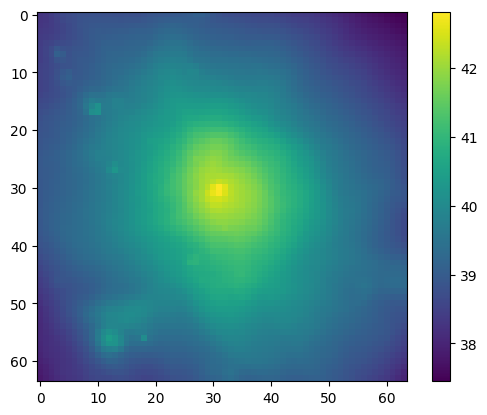

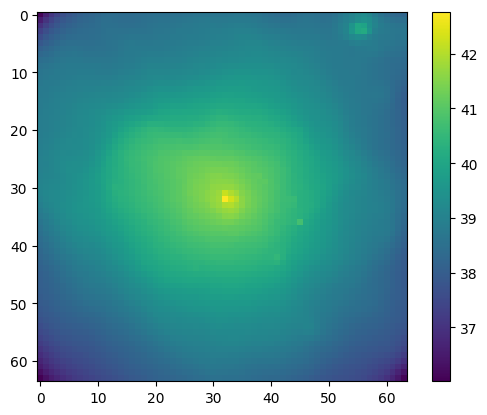

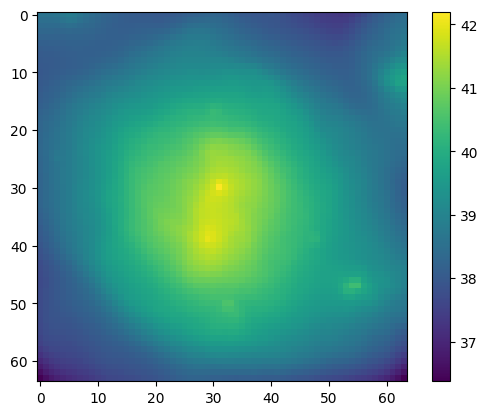

/var/tmp/tol/ipykernel_384111/787402369.py:2: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(image[0]))


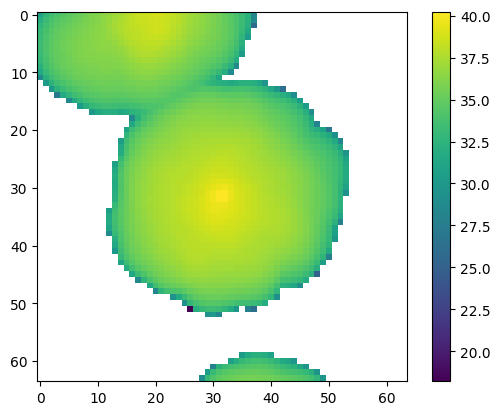

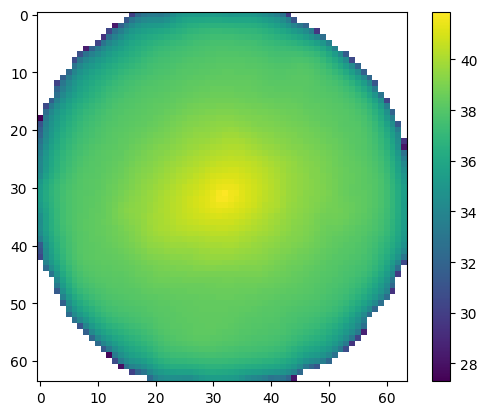

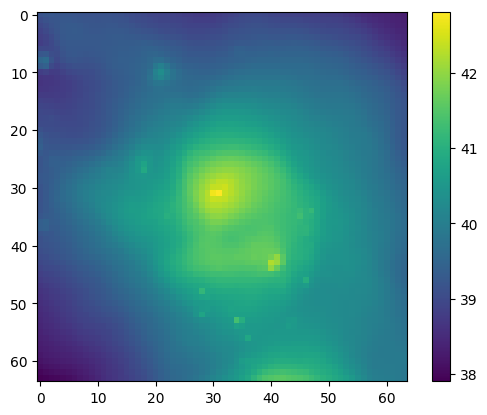

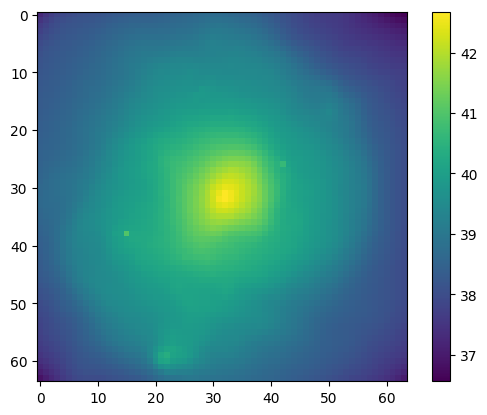

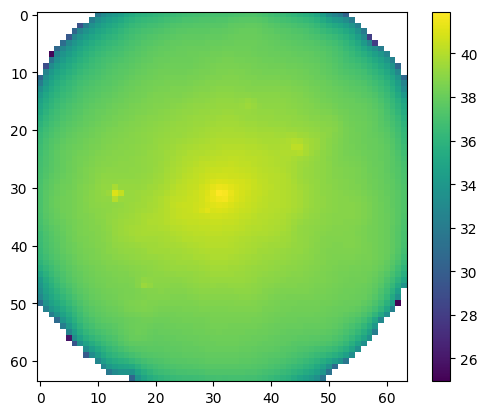

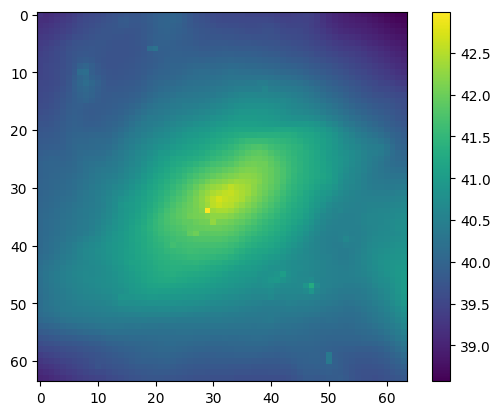

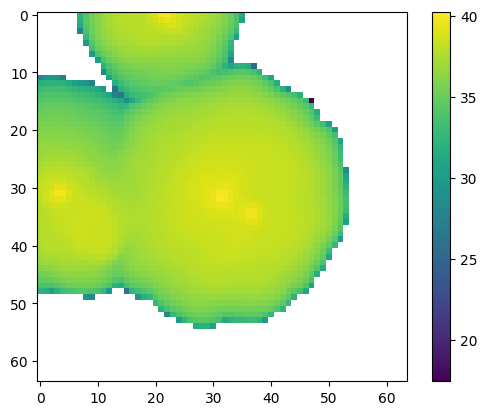

In [22]:
for image in data.images[:10]:
    plt.imshow(np.log10(image[0]))
    plt.colorbar()
    plt.show()

(7941, 2, 64, 64)


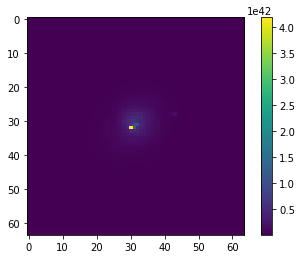

In [69]:
print(data.images.shape)
import matplotlib.pyplot as plt
plt.imshow(data.images[-4, 0])
plt.colorbar()
plt.show()

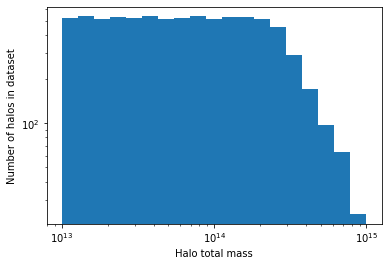

In [20]:
logbins = np.logspace(np.log10(np.min(data.masses)), np.log10(np.max(data.masses)), 20)
plt.hist(data.masses, bins=logbins)
plt.yscale("log")
plt.xscale("log")
plt.ylabel("Number of halos in dataset")
plt.xlabel("Halo total mass")
plt.show()

# make single obs data

In [75]:
data = Data(p)
halo_nr = 1002

print(np.log10(data.soap_file[f"{p['selection_type']}/TotalMass"][halo_nr]))
low, high, sz = data.make_obs(halo_nr, rotate=True, sz=True)

12.839786


/home/tol/.local/lib/python3.11/site-packages/swiftsimio/objects.py:261: RuntimeWarning: Mixing ufunc arguments with and without cosmo_factors, continuing assuming provided cosmo_factor (a**0.0 at a=1.0) for all arguments.
  warnings.warn(


/home/tol/.local/lib/python3.11/site-packages/swiftsimio/objects.py:261: RuntimeWarning: Mixing ufunc arguments with and without cosmo_factors, continuing assuming provided cosmo_factor (a**(-2.0) at a=1.0) for all arguments.
  warnings.warn(


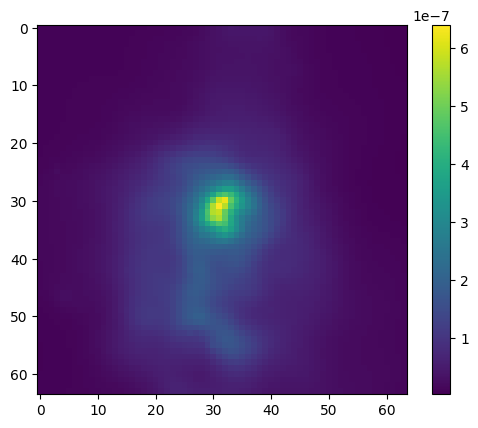

In [78]:
plt.imshow((sz))
plt.colorbar()
plt.show()

In [13]:
soapfile = h5py.File("/net/hypernova/data2/FLAMINGO/L1000N1800/HYDRO_FIDUCIAL/SOAP/halo_properties_0077.hdf5", "r")
mask = sw.mask("/net/hypernova/data2/FLAMINGO/L1000N1800/HYDRO_FIDUCIAL/snapshots/flamingo_0077/flamingo_0077.hdf5")

(cosmo_array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], 'erg/s'), cosmo_array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], 'erg/s'))


In [14]:
print(soapfile["VR/StructureType"][12902130])

10


In [57]:
halo_data = data.make_obs(5772976)

(421128,)
[0.57666016 0.57666016 0.57666016 ... 0.8222656  0.8222656  0.8222656 ] dimensionless (Comoving)


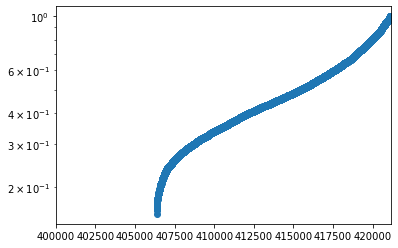

In [85]:
print((halo_data.gas.masses).shape)
print(np.sort(halo_data.gas.last_agnfeedback_scale_factors)[-4000:-1000])
plt.scatter(range(len(halo_data.gas.masses)), np.sort(halo_data.gas.last_agnfeedback_scale_factors))
# plt.xscale("log")
plt.xlim(400000, 421128)
plt.yscale("log")

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'black_holes', 'create_particle_datasets', 'dark_matter', 'filename', 'gas', 'get_metadata', 'get_units', 'mask', 'metadata', 'neutrinos', 'stars', 'units']


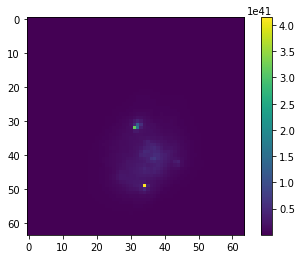

In [56]:
for i in range(5772976, 5772976+1):
    red_flux, blue_flux = data.make_obs(i)
    plt.imshow(red_flux)
    plt.colorbar()
    plt.show()

In [24]:
# def make_obs(halo_index=0):
#     print(soapfile["SO/500_crit/XRayLuminosity"][halo_index])
#     position = soapfile["SO/500_crit/CentreOfMass"][halo_index] * unyt.Mpc
#     # radius = soapfile["SO/500_crit/SORadius"][halo_index] * unyt.Mpc
#     radius = 2*unyt.Mpc
#     load_box = [[position[0] - radius, position[0] + radius], 
#                 [position[1] - radius, position[1] + radius], 
#                 [position[2] - radius, position[2] + radius]]
#     mask.constrain_spatial(load_box)
#     halo_data = sw.load("/net/hypernova/data2/FLAMINGO/L1000N1800/HYDRO_FIDUCIAL/snapshots/flamingo_0077/flamingo_0077.hdf5", mask=mask)

#     halo_mask = halo_data.gas.last_agnfeedback_scale_factors < 0.999
    

#     halo_data.gas.flux = halo_data.gas.xray_luminosities.erosita_low
#     flux = sw.visualisation.projection.project_gas(
#         halo_data,
#         resolution=64, 
#         project="flux", 
#         region=[position[0] - radius, position[0] + radius, position[1] - radius, position[1] + radius],
#         parallel = True,
#         mask = halo_mask
#     )
#     flux = np.float64(flux)
#     flux.convert_to_units(unyt.erg/unyt.s / unyt.kpc**2)

#     return flux

[8.67039471e+41 5.27437669e+40 6.16591649e+41]
7.736604162846131e+43 erg/(kpc**2*s) (Comoving)


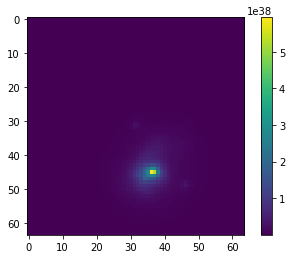

# test compton-y

In [2]:
p["cosmology"] = "HYDRO_PLANCK"
data = Data(p)

In [3]:
mask = sw.mask(data.sw_path)
position = data.soap_file[f"{p['selection_type']}/CentreOfMass"][0] * unyt.Mpc
radius = p['obs_radius'] * unyt.Mpc
load_box = [[position[0] - radius, position[0] + radius], 
            [position[1] - radius, position[1] + radius], 
            [position[2] - radius, position[2] + radius]]
mask.constrain_spatial(load_box)

halo_data = sw.load(data.sw_path, mask=mask)

In [6]:
# for i in dir(halo_data.gas.compton_yparameters):
#     print(i)
print(halo_data.gas.xray_photon_luminosities.erosita_low[:20])
print(halo_data.gas.xray_luminosities.erosita_low[:20])
print(halo_data.gas.compton_yparameters)

[1.31254699e+64 0.00000000e+00 0.00000000e+00 0.00000000e+00
 9.92444936e+63 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 5.59857215e+63
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00] 0.00102271448879616/Gyr (Comoving)
[39.125    0.       0.       0.      70.       0.       0.       0.
  0.       0.       0.       0.       0.       0.       0.      31.96875
  0.       0.       0.       0.     ] 10.697030298874*Mpc**2*Msun/Gyr**3 (Comoving)
[1.37134748e-12 5.75095527e-14 4.49085213e-14 ... 2.13162821e-13
 2.82796009e-12 4.32542890e-13] Mpc**2 (Comoving)


In [47]:
d = halo_data.metadata.cosmology
print(halo_data.metadata.cosmology)
print(d["Universe age [internal units]"]*1000 - 0.015)
print( (d["Omega_m"] / d["Omega_lambda"] * np.sinh(3.0/2.0 * np.sqrt(d["Omega_lambda"]) * d["H0 [internal units]"] * (d["Hubble time [internal units]"] - 0.000015))**2)**(1./3.))
# print(dir(halo_data.metadata.cosmology.values))
# print(dir(astropy))

{'Cosmological run': array([1], dtype=int32), 'Critical density [internal units]': array([12.87106552]), 'H [internal units]': array([68.09999997]), 'H0 [internal units]': array([68.09999997]), 'Hubble time [internal units]': array([0.01468429]), 'Lookback time [internal units]': array([9.02056208e-16]), 'M_nu_eV': array([0.06]), 'N_eff': array([3.04400163]), 'N_nu': array([1.]), 'N_ur': array([2.0308]), 'Omega_b': array([0.0486]), 'Omega_cdm': array([0.256011]), 'Omega_g': array([5.33243487e-05]), 'Omega_k': array([2.5212783e-09]), 'Omega_lambda': array([0.693922]), 'Omega_m': array([0.304611]), 'Omega_nu': array([0.00138908]), 'Omega_nu_0': array([0.00138908]), 'Omega_r': array([7.79180471e-05]), 'Omega_ur': array([2.45936984e-05]), 'Redshift': array([0.]), 'Scale-factor': array([1.]), 'T_CMB_0 [K]': array([2.7255]), 'T_CMB_0 [internal units]': array([2.7255]), 'T_nu_0 [eV]': array([0.00016819]), 'T_nu_0 [internal units]': array([1.9517578]), 'Universe age [internal units]': array([0

# gas fractions


In [2]:
p["soapfile"] = "halo_properties_0077.hdf5"
p["snapshot"] = "flamingo_0077/flamingo_0077.hdf5"
p["snapshot_folder"] = "snapshots"
p["simsize"] = "L1000N1800"
data = Data(p)
gasmass = data.soap_file["SO/500_crit/GasMass"][()]
totalmass = data.soap_file["SO/500_crit/TotalMass"][()]
indices = (gasmass > 0)*(totalmass>0)*(totalmass>1e13)*(totalmass<1e15)
# indices = np.logical_and(gasmass > 0, totalmass > 0)
gasmass = gasmass[indices]
totalmass = totalmass[indices]
massfractions = gasmass / totalmass
print(indices.shape)

(13235708,)


In [4]:
print(gasmass.shape)

(92000,)


Text(0, 0.5, 'Gas fraction')

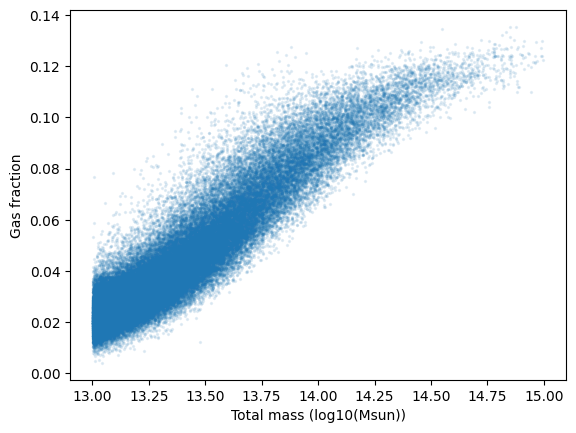

In [54]:
plt.scatter(np.log10(totalmass), massfractions, s=2, alpha=0.1)
plt.xlabel("Total mass (log10(Msun))")
plt.ylabel("Gas fraction")

In [43]:
bins = np.logspace(13, 15, 20)

gasfrac = []
mass = []
for i in range(len(bins)-1):
    indices = np.logical_and(totalmass > bins[i], totalmass < bins[i+1])

    gasfrac.append(np.median(massfractions[indices]))
    mass.append(np.median(totalmass[indices]))
    

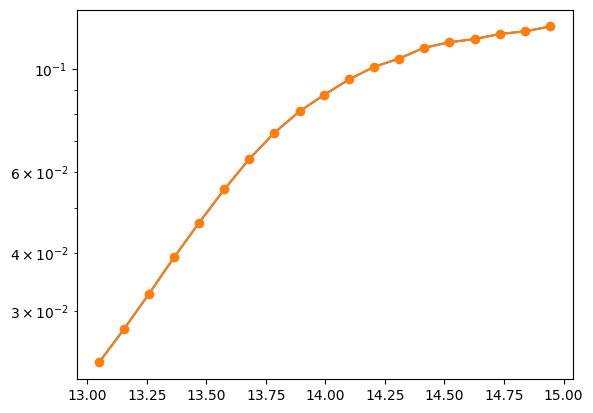

In [48]:
plt.plot(np.log10(mass), gasfrac)
plt.plot(np.log10(mass2), gasfrac2, marker="o")